In [2]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
!pip install -q accelerate
!pip install -q gluonts ujson

In [45]:
# 加载数据集
from datasets import load_dataset
dataset = load_dataset("ett")

D:\Anaconda3\envs\pytorch\lib\site-packages\datasets\load.py:1429: FutureWarning: The repository for ett contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ett
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/240 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/120 [00:00<?, ? examples/s]

In [47]:
# 数据的结构，应该是字典，里面划分了训练集测试集验证集，每个数据集里面的信息有特征名称，样本数据量
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 1
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 240
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 120
    })
})

In [60]:
train_example = dataset['test']
len(train_example['target'][0])

8664

In [28]:
dataset['train'][5]['start']

datetime.datetime(1985, 1, 1, 0, 0)

In [34]:
dataset['train'][5]['target']

[12570.0,
 12691.0,
 18729.0,
 16028.0,
 13644.0,
 12265.0,
 13567.0,
 14020.0,
 14726.0,
 21508.0,
 21294.0,
 16864.0,
 14303.0,
 14154.0,
 20455.0,
 18017.0,
 16017.0,
 14501.0,
 15562.0,
 16007.0,
 15814.0,
 24914.0,
 25130.0,
 19830.0,
 17112.0,
 18263.0,
 23359.0,
 22270.0,
 19551.0,
 15875.0,
 17820.0,
 19520.0,
 19505.0,
 29795.0,
 26767.0,
 21954.0,
 19925.0,
 20403.0,
 29513.0,
 25376.0,
 20490.0,
 17008.0,
 21418.0,
 22857.0,
 22140.0,
 33758.0,
 28969.0,
 23733.0,
 20554.0,
 20349.0,
 29641.0,
 26369.0,
 21336.0,
 16283.0,
 19123.0,
 19054.0,
 18527.0,
 28495.0,
 27553.0,
 22432.0,
 19053.0,
 21203.0,
 26916.0,
 24709.0,
 20301.0,
 16459.0,
 21033.0,
 21897.0,
 20602.0,
 31817.0,
 30145.0,
 25198.0,
 19345.0,
 19944.0,
 26459.0,
 22863.0,
 21849.0,
 17787.0,
 19816.0,
 20923.0,
 22140.0,
 30358.0,
 30990.0,
 23152.0,
 20082.0,
 22220.0,
 27497.0,
 30539.0,
 23982.0,
 19210.0,
 22829.0,
 25709.0,
 25799.0,
 36094.0,
 35057.0,
 25213.0,
 20973.0,
 24715.0,
 33102.0,
 29677.0,


In [29]:
dataset['train'][5]['feat_static_cat']

[5]

In [33]:
dataset['train'][5]['feat_dynamic_real']

In [31]:
dataset['train'][5]['item_id']

'T6'

In [22]:
len(dataset['train'][5]['target']),len(dataset['validation'][5]['target']),len(dataset['test'][5]['target'])
# 测试集比验证机多24个，验证集比训练集多24个

(216, 240, 264)

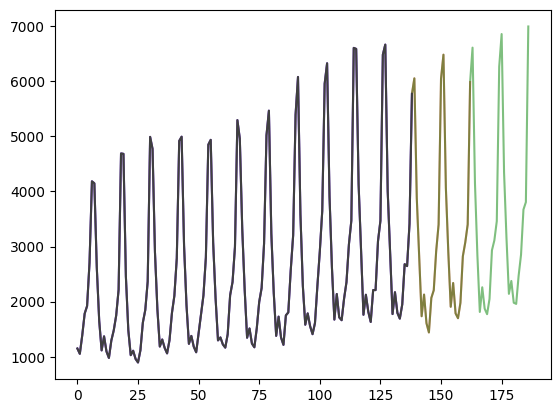

In [26]:
# 上述训练集和测试集验证集来说，测试验证集比训练集多了预测长度个数据。
import matplotlib.pyplot as plt
train_example = dataset['train'][0]
validation_example = dataset['validation'][0]
test_example = dataset['test'][0]
figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)
axes.plot(test_example["target"], color="green", alpha=0.5)
plt.show()

了解完数据集，我们开始讲数据转化为dataloader，首先对上述数据进行处理，得到规格标准的数据/


In [39]:
from functools import lru_cache

import pandas as pd
import numpy as np
freq = "1M"
prediction_length = 24
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [40]:
from functools import partial
dataset['train'].set_transform(partial(transform_start_field, freq=freq))
dataset['test'].set_transform(partial(transform_start_field, freq=freq))

In [41]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


In [42]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)


[<function month_of_year at 0x00000249A6396F80>]


In [43]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(dataset['train'])],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)


In [44]:
model.config.distribution_output

'student_t'

In [61]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)



In [68]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,)
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),

            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            )
        ]
    )


In [69]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [70]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [71]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [72]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=dataset['train'],
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=dataset['test'],
    batch_size=64,
)


In [74]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())


AttributeError: 'generator' object has no attribute 'items'

In [78]:
batch = next(iter(train_dataloader))

StopIteration: 

In [84]:
for i in train_dataloader:
    print(i)

